<a href="https://colab.research.google.com/github/jht301/OlympicAthleteLookup/blob/main/Olympic_Odds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

####Import-ant Stuff

In [ ]:
import pandas as pd
import sqlite3
import ipywidgets as widgets
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import display, clear_output
from datetime import date, datetime


####Get The Database

In [ ]:
file_url='https://www.dropbox.com/scl/fi/7x8epscyiij1x2uo89ep0/olympic_historical_dataset.db?rlkey=wonved4c0nj0v7m6csahb9h49&st=fzfbtb1s&dl=0'
file_name=file_url.split('/')[-1]
!wget {file_url}

--2024-07-12 14:46:07--  https://www.dropbox.com/scl/fi/7x8epscyiij1x2uo89ep0/olympic_historical_dataset.db?rlkey=wonved4c0nj0v7m6csahb9h49
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf55ebeb55c0eb34c40b57e476d.dl.dropboxusercontent.com/cd/0/inline/CWlWA0asnsvAF5tO7kvxNXz0cVaLwW21mY7l4BA7DJAX35cJ5ztxe41Gj4upBUyhhzw45pmId1gfJkPNddPOcevstM5dXzBhoemWs-2HOKifMjOTBacI_GYf7pwaT6T-oF7DTpxaVDc5PdQ6qB4d_WDS/file# [following]
--2024-07-12 14:46:07--  https://ucf55ebeb55c0eb34c40b57e476d.dl.dropboxusercontent.com/cd/0/inline/CWlWA0asnsvAF5tO7kvxNXz0cVaLwW21mY7l4BA7DJAX35cJ5ztxe41Gj4upBUyhhzw45pmId1gfJkPNddPOcevstM5dXzBhoemWs-2HOKifMjOTBacI_GYf7pwaT6T-oF7DTpxaVDc5PdQ6qB4d_WDS/file
Resolving ucf55ebeb55c0eb34c40b57e476d.dl.dropboxusercontent.com (ucf55ebeb55c0eb34c40b57e476d.dl.dropboxusercontent.com)... 162

####Get Connected, For Free

In [ ]:
conn = sqlite3.connect('/content/olympic_historical_dataset.db?rlkey=wonved4c0nj0v7m6csahb9h49')

###Load up!

In [ ]:
# Define the SQL query
query = """
SELECT
    a.athlete_id,
    a.name,
    a.born,
    a.country_noc,
    ar.medal,
    ar.event,
    ar.sport,
    og.year
FROM
    Olympic_Athlete_Bio a
JOIN
    Olympic_Athlete_Event_Results ar ON a.athlete_id = ar.athlete_id
JOIN
    Olympics_Games og ON ar.edition_id = og.edition_id
WHERE
    og.year = 2020
    AND ar.medal IS NOT NULL
ORDER BY a.athlete_id;
  """

# Execute the query and load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)



# Showing Our Work

###My Country My Pride

Certain countries consistently perform better in the games throughout the years. Here are the top 10.

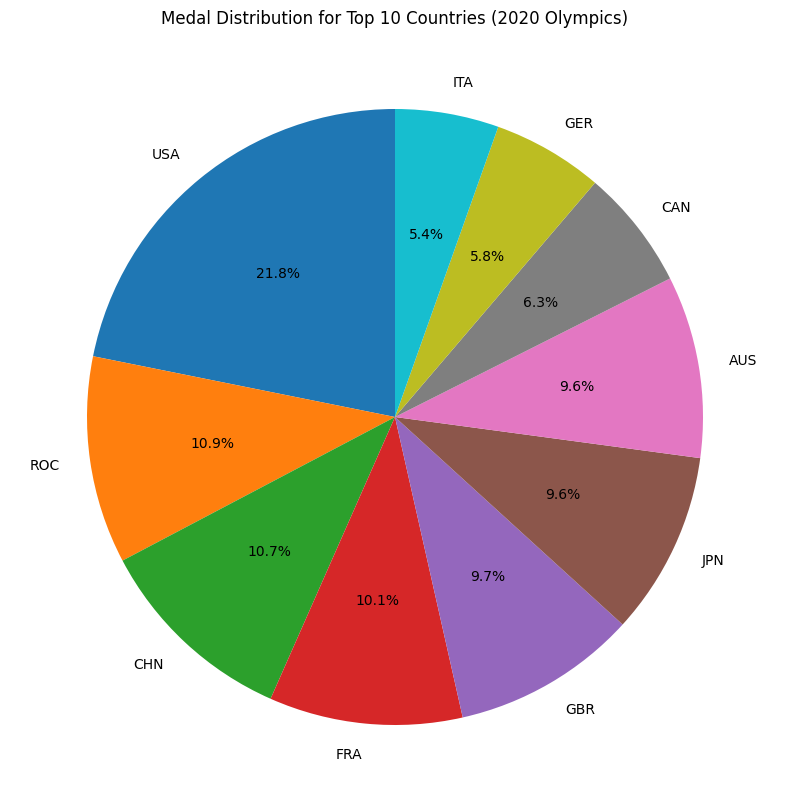

In [ ]:
# Count the number of medals won by each country
medal_counts = df['country_noc'].value_counts()

# Select the top 10 countries
top_10_countries = medal_counts.head(10)

# Plot the pie chart for the top 10 countries
plt.figure(figsize=(10, 10))
plt.pie(top_10_countries, labels=top_10_countries.index, autopct='%1.1f%%', startangle=90)
plt.title('Medal Distribution for Top 10 Countries (2020 Olympics)')
plt.show()



###Winning twice is easy, 3 times not so much...

Strong athletes will win 2 games in a row but it may be best not to bet on their 3rd win. This chart below shows a major dropoff in the number of athletes with wins in 2 games vs wins in 3 or more.

In [ ]:
# SQL query to find athletes with consecutive wins
query = """
WITH ConsecutiveWins AS (
    SELECT
        athlete_id,
        year,
        LEAD(year, 1, 0) OVER (PARTITION BY athlete_id ORDER BY year) AS next_year,
        medal
    FROM
        (
            SELECT DISTINCT
                ar.athlete_id,
                og.year,
                ar.medal
            FROM
                Olympic_Athlete_Event_Results ar
            JOIN
                Olympics_Games og ON ar.edition_id = og.edition_id
            WHERE
                ar.medal IS NOT NULL
        )
)
SELECT
    athlete_id,
    COUNT(*) AS consecutive_win_count
FROM
    ConsecutiveWins
WHERE
    next_year - year = 4 AND medal IS NOT NULL
GROUP BY
    athlete_id
HAVING
    COUNT(*) > 1;
"""

# Execute the query and load the data into a pandas DataFrame
df_consecutive_wins = pd.read_sql_query(query, conn)

# Print the number of athletes with consecutive wins
num_athletes_consecutive_wins = len(df_consecutive_wins)
print("Number of athletes with consecutive wins:", num_athletes_consecutive_wins)

# Display the DataFrame with athletes who have consecutive wins
display(df_consecutive_wins)



Number of athletes with consecutive wins: 1088


,athlete_id,consecutive_win_count
0,916,2
1,933,2
2,1352,3
3,1371,2
4,1372,2
...,...,...
1083,128731,2
1084,128733,2
1085,128737,2
1086,138421,2


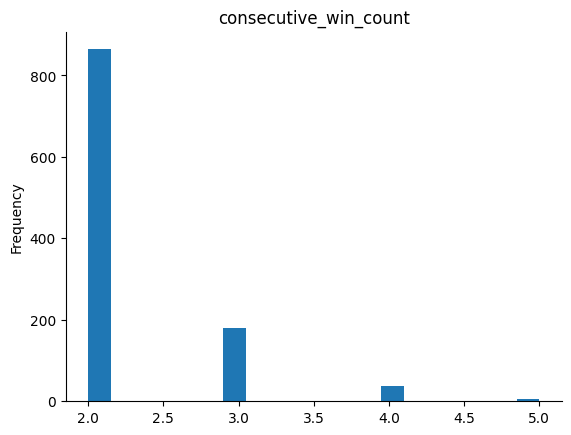

In [ ]:
# @title consecutive_win_count

from matplotlib import pyplot as plt
df_consecutive_wins['consecutive_win_count'].plot(kind='hist', bins=20, title='consecutive_win_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

###Age Is But a Number, Right?

We wanted to know when athletes were in their prime. This chart shows that the most medals are awarded to athletes ranging in age between 20 and 29 with a severe dropoff for each age group after.

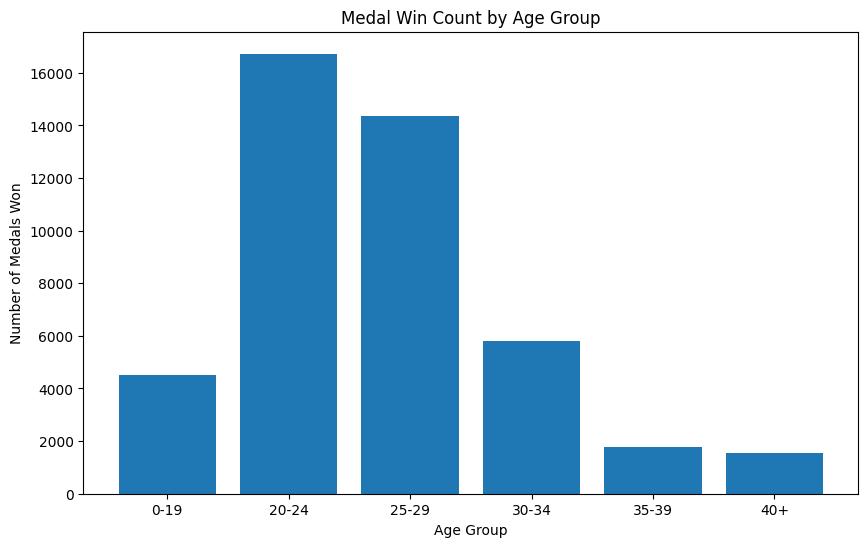

In [ ]:
# SQL query to get medal counts by age group
#Calculates by grabbing birth dates and comparing to dates they won
query = """
SELECT
    CASE
        WHEN age_at_games BETWEEN 0 AND 19 THEN '0-19'
        WHEN age_at_games BETWEEN 20 AND 24 THEN '20-24'
        WHEN age_at_games BETWEEN 25 AND 29 THEN '25-29'
        WHEN age_at_games BETWEEN 30 AND 34 THEN '30-34'
        WHEN age_at_games BETWEEN 35 AND 39 THEN '35-39'
        ELSE '40+'
    END AS age_group,
    COUNT(medal) AS medal_count
FROM (
    SELECT
        a.athlete_id,
        a.born,
        og.year,
        CAST(SUBSTR(og.year, 1, 4) AS INT) - CAST(SUBSTR(a.born, -4) AS INT) - (
            CASE
                WHEN CAST(SUBSTR(a.born, 1, INSTR(a.born, ' ') - 1) AS INT) > 7 THEN 1
                WHEN CAST(SUBSTR(a.born, 1, INSTR(a.born, ' ') - 1) AS INT) = 7 AND CAST(SUBSTR(a.born, INSTR(a.born, ' ') + 1, INSTR(SUBSTR(a.born, INSTR(a.born, ' ') + 1), ' ') - 1) AS INT) > 23 THEN 1
                ELSE 0
            END
        ) AS age_at_games, -- Calculate age directly in SQL
        ar.medal
    FROM
        Olympic_Athlete_Bio a
    JOIN
        Olympic_Athlete_Event_Results ar ON a.athlete_id = ar.athlete_id
    JOIN
        Olympics_Games og ON ar.edition_id = og.edition_id
    WHERE
        ar.medal IS NOT NULL
)
GROUP BY age_group
ORDER BY age_group;
"""

# Execute the query and load the data into a pandas DataFrame
df_age_group_medals = pd.read_sql_query(query, conn)

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(df_age_group_medals['age_group'], df_age_group_medals['medal_count'])
plt.xlabel('Age Group')
plt.ylabel('Number of Medals Won')
plt.title('Medal Win Count by Age Group')
plt.show()

# Athlete Ranking Lookup

This tool allows you to look up an athlete by name and see how they may perform in future games. It takes the queries done in the previous steps and uses a formula to calculate a ranking. The athlete is awarded * dependant on where they land among the favorited groups for each criteria.

In [ ]:
# Function to calculate age
def calculate_age(born):
    try:
        # Attempt to parse in ISO format first
        born_date = date.fromisoformat(str(born))
    except ValueError:
        try:
          # If ISO format fails, try a different format
          born_date = datetime.strptime(born, '%d %B %Y').date()
        except:
          #if other format fails use a dummy date
          born_date = datetime(1800,1,1)

    today = date.today()
    age = today.year - born_date.year - ((today.month, today.day) < (born_date.month, born_date.day))
    return age


    ###Calculates an ethletes ranking based on age, previous wins, and country
def calculate_ranking(country, age, id):
    ranking = ""
    consecutive_wins = 0
    #get consecutive wins from dataframe above
    cw_result = df_consecutive_wins.loc[df_consecutive_wins['athlete_id'] == id, 'consecutive_win_count']
    if cw_result.empty:
        consecutive_wins = 0
    else:
      consecutive_wins = cw_result.iloc[0]
    #If they are in the top 10 countries
    if country in top_10_countries:
        ranking+="*"
    #If they won in the previous year but not 2 games ago then +2
    if consecutive_wins > 0 and consecutive_wins < 2:
        ranking+="**"

    #if they won in previous 2 then +1
    if consecutive_wins > 1 and consecutive_wins <3:
        ranking+="*"

    #If they are in the right age range +2
    if age <=29 and age >=20:
        ranking+="**"
#if they are in the next best age range +1
    elif age <=39 and age >=30:
        ranking+="*"



    return ranking


# Function to fetch and display athlete data
def fetch_athlete_data(name_filter):
    query = """
    SELECT
        a.athlete_id,
        a.name,
        a.country_noc AS Team,
        ar.sport AS Sport,
        COUNT(ar.medal) AS total_medal_count,
        a.born
    FROM
        Olympic_Athlete_Bio a
    JOIN
        Olympic_Athlete_Event_Results ar ON a.athlete_id = ar.athlete_id
    WHERE
        a.name LIKE ?
        AND ar.medal IS NOT NULL
    GROUP BY
        a.name, a.country_noc, ar.sport
    """

    # Use parameterization to prevent SQL injection
    params = ('%' + name_filter + '%',)
    df = pd.read_sql_query(query, conn, params=params)

    # Calculate age for each athlete
    df['Current Age'] = df['born'].apply(calculate_age)
    df = df.drop('born', axis=1)  # Remove the 'born' column
    df['Ranking'] = df.apply(lambda row: calculate_ranking(row['Team'], row['Current Age'], row['athlete_id']), axis=1)

    df = df.drop('athlete_id', axis=1)
    # Display the results in a table
    display(df)


# Create a text input widget for the athlete's name
name_input = widgets.Text(
    description='Athlete:',
    placeholder='Enter name or part of name',

)

# Create a button to trigger the search
search_button = widgets.Button(description='Search')

# Define the on_click event handler for the button
def on_button_clicked(b):
    clear_output()
    display(name_input, search_button)
    fetch_athlete_data(name_input.value)

search_button.on_click(on_button_clicked)

# Display the input widget and button
display(name_input, search_button)


Text(value='Robert', description='Athlete:', placeholder='Enter name or part of name')

Button(description='Search', style=ButtonStyle())

,name,Team,Sport,total_medal_count,Current Age,Ranking
0,Roberto Carlos,BRA,Football,1,51,
1,Alvin Robertson,USA,Basketball,1,61,*
2,Arthur Robertson,GBR,Athletics,2,145,*
3,Bill Roberts,GBR,Athletics,1,112,*
4,Bruce Robertson,CAN,Rowing,1,62,*
...,...,...,...,...,...,...
185,Sonia Robertson,ZIM,Hockey,1,77,
186,Susan Roberts,RSA,Swimming,1,85,
187,Thomas Robertson-Aikman,GBR,Curling,1,164,*
188,Tiffany Roberts,USA,Football,2,47,*
